In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import umap
from sklearn.cluster import KMeans

In [10]:
df = pd.read_csv('Data/filtered_data.csv')

In [11]:
df.head()

,Hospital Service Area,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,...,CCSR Diagnosis Code,CCSR Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator,Total Charges
0,New York City,Kings,Kings County Hospital Center,18 to 29,M,Black/African American,Not Span/Hispanic,1.0,Emergency,Home or Self Care,...,MBD025,MHT001,776.0,20.0,1.0,Minor,Medical,Self-Pay,Y,6306.30
1,New York City,Kings,Kings County Hospital Center,70 or Older,F,Black/African American,Not Span/Hispanic,2.0,Emergency,Home or Self Care,...,INJ008,ADM001,55.0,1.0,1.0,Moderate,Medical,Self-Pay,Y,29392.77
2,New York City,Manhattan,Bellevue Hospital Center,30 to 49,F,Black/African American,Not Span/Hispanic,2.0,Elective,Home or Self Care,...,NEO073,FRS010,519.0,13.0,1.0,Minor,Surgical,Self-Pay,N,33203.77
3,New York City,Bronx,Jacobi Medical Center,0 to 17,M,Black/African American,Not Span/Hispanic,2.0,Newborn,Home or Self Care,...,PNL001,ADM010,640.0,15.0,1.0,Minor,Medical,Self-Pay,N,14388.76
4,New York City,Bronx,Jacobi Medical Center,50 to 69,M,Black/African American,Not Span/Hispanic,1.0,Emergency,Home or Self Care,...,MBD001,MHT001,751.0,19.0,1.0,Minor,Medical,Self-Pay,Y,5772.45


### Scaling necessary columns

In [12]:
columns_to_scale = ['APR DRG Code', 'APR MDC Code']

selected_data = df[columns_to_scale]

print("Missing values in selected_data before scaling:")
print(selected_data.isna().sum())

Missing values in selected_data before scaling:
APR DRG Code    0
APR MDC Code    0
dtype: int64


In [13]:
scaler = MinMaxScaler()

scaler.fit(selected_data)

scaled_data = scaler.transform(selected_data)

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

In [14]:
if not df.index.equals(scaled_df.index):
    scaled_df.set_index(df.index, inplace=True)

In [15]:
df[columns_to_scale] = scaled_df

### Dummy encoding and dropping the remaining unnecessary columns

In [16]:
df_encoded = pd.get_dummies(df, columns=['Hospital Service Area', 'Hospital County', 'Facility Name'
                                         , 'Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission'
                                         , 'Patient Disposition', 'CCSR Diagnosis Code', 'CCSR Procedure Code'
                                         , 'APR Risk of Mortality', 'APR Medical Surgical Description'
                                         , 'Emergency Department Indicator']
                            ,prefix=['Hospital Service Area', 'Hospital County', 'Facility'
                                     , 'Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission'
                                     , 'Patient Disposition', 'CCSR Diagnosis Code', 'CCSR Procedure Code'
                                     , 'APR Risk of Mortality', 'APR Medical Surgical Description'
                                     , 'Emergency Department Indicator'])

In [17]:
columns_to_drop_2 = ['Hospital Service Area', 'Hospital County'
                  , 'Facility Name', 'Age Group', 'Gender', 'Race', 'Ethnicity'
                  , 'Type of Admission', 'Patient Disposition', 'CCSR Diagnosis Code'
                  , 'CCSR Procedure Code', 'APR Risk of Mortality'
                  , 'APR Medical Surgical Description', 'Payment Typology 1'
                  , 'Emergency Department Indicator']

In [18]:
for col in columns_to_drop_2:
    try:
        df_encoded.drop(columns=[col], inplace=True)
    except:
        print(col)

Hospital Service Area
Hospital County
Facility Name
Age Group
Gender
Race
Ethnicity
Type of Admission
Patient Disposition
CCSR Diagnosis Code
CCSR Procedure Code
APR Risk of Mortality
APR Medical Surgical Description
Emergency Department Indicator


### Testing a Linear Regression Model

In [19]:
y = df_encoded['Total Charges']
X = df_encoded.drop(columns =['Total Charges'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1.6032355682233093e+28
R-squared: -6.840362941284886e+19


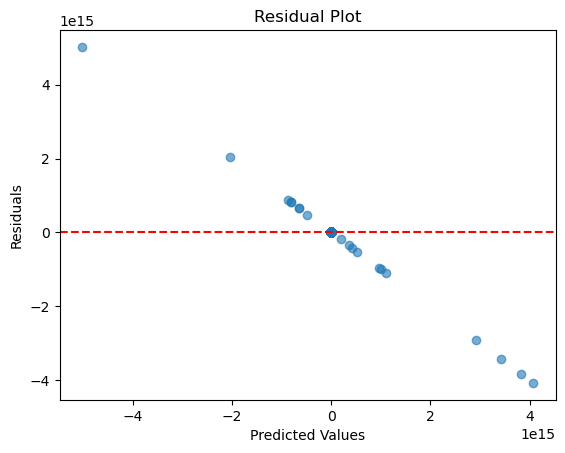

In [21]:
residuals = y_test - y_pred

# Create the residual plot
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

I think I got a negative r-squared score because linear regression allows predictive values below zero, but that doesn't make sense given our data (we cannot have a negative hospital charge). So going to try other models that are more appropriate for the data

### Poisson Regression

In [22]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())

poisson_results = poisson_model.fit()

print(poisson_results.summary())

y_pred = poisson_results.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Total Charges   No. Observations:                21871
Model:                            GLM   Df Residuals:                    21077
Model Family:                 Poisson   Df Model:                          793
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8789e+07
Date:                Sun, 30 Jul 2023   Deviance:                   3.7335e+07
Time:                        15:56:17   Pearson chi2:                 3.97e+07
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [ ]:
residuals = y_test_actual - y_pred

# Create the residual plot
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#### It looks like we're really overfitting with this model. Going to try some regularization methods

### Ridge Regression Model

In [22]:
y = df_encoded['Total Charges']
X = df_encoded.drop('Total Charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [23]:
ridge_model = Ridge(alpha=1.0)


ridge_cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')
ridge_mean_r2 = np.mean(ridge_cv_scores)
ridge_mean_r2

0.788297469919814

In [24]:
selected_model = Ridge(alpha=1.0)  # You can choose Ridge or Lasso based on the results
selected_model.fit(X_train, y_train)

Ridge()

In [25]:
y_pred = selected_model.predict(X_test)

test_r2 = selected_model.score(X_test, y_test)
test_mse = mean_squared_error(y_test, y_pred)

print(test_r2)
print(test_mse)

0.7870171887109146
49918640.488791786


### Lasso Regression Model

In [26]:
lasso_model = Lasso(alpha=1.0)

lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('r2:', r2)

Mean Squared Error: 49799661.67998513
r2: 0.7875248235530365


### Random Forest Regressor Model

In [28]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
print(rfr.score(X_test,y_test))

preds = rfr.predict(X_test)

print(rfr.score(X_test,y_test))
mse = mean_squared_error(y_test, preds)
print("Mean Squared Error (MSE):", mse)

0.8176226809365033
0.8176226809365033
Mean Squared Error (MSE): 42745364.137781575


It looks like the Random Forest model gives me the best initial score. I'm going to try some dimensionality reduction techniques, as well as clustering to help improve (another jupyter notebook)